Zadanie 3.

In [404]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [405]:
def ispermutation( p ):
    for i in range(p.shape[0]):
        if i not in p:
            print("indeks", i)
            return False
    return True

def PMX(ind1, ind2):
    #print(f"individual 1:{ind1}\nindividual 2:{ind2}")
    s = ind1.shape[0]
    o1 = np.zeros(s, dtype=np.int32)
    o2 = np.zeros(s, dtype=np.int32)
    beg = np.random.randint(s - 1)
    end = np.random.randint(beg + 1, s)

    o1[beg:end] = ind2[beg:end]
    o2[beg:end] = ind1[beg:end]

    pairing = {}
    for i in range(beg, end):
        pairing[o1[i]] = o2[i]
        pairing[o2[i]] = o1[i]
    
    for i in range(0, beg):
        x = ind1[i]
        if x in o2[beg:end]:
            o2[i] = pairing[x]
        else:
            o2[i] = x

        y = ind2[i]
        if y in o1[beg:end]:
            o1[i] = pairing[y]
        else:
            o1[i] = y

    for i in range(end, s):
        x = ind1[i]
        if x in o2[beg:end]:
            o2[i] = pairing[x]
        else:
            o2[i] = x

        y = ind2[i]
        if y in o1[beg:end]:
            o1[i] = pairing[y]
        else:
            o1[i] = y

    return o1, o2

def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

def transposition_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    tmp = q[i]
    q[i] = q[j]
    q[j] = tmp
    return q

def simplecrossover(x, y):
    change = np.random.normal(0, 1)
    return ( x + change * (y - x) ), ( y + change * (x - y) )

def simplemutation(x, mutation_probability, lowbound, highbound):
    newx = x
    for i in range( x.shape[0] ):
        if np.random.random() < mutation_probability:
            newx[i] = x[i] + np.random.normal(loc = 0, scale = highbound - lowbound)
        else:
            newx[i] = x[i]
    return newx

Testing functions:

In [406]:
def SCH1(x):
    return x ** 2
def SCH2(x):
    return (x - 2) ** 2

def POL1(x):
    a1 = 0.5 * np.sin(1) - 2 * np.cos(1) + np.sin(2) - 1.5 * np.cos(2)
    a2 = 1.5 * np.sin(1) - np.cos(1) + 2 * np.sin(2) - 0.5 * np.cos(2)
    b1 = 0.5 * np.sin(x[0]) - 2 * np.cos(x[0]) + np.sin(x[1]) - 1.5 * np.cos(x[1])
    b2 = 1.5 * np.sin(x[0]) - np.cos(x[0]) + 2 * np.sin(x[1]) - 0.5 * np.cos(x[1])
    return 1 - np.exp(1 + (a1 - b1) ** 2 + (a2 - b2) ** 2)
def POL2(x):
    return (x[0] + 3) ** 2 + (x[1] + 1) ** 2

def FON1(x):
    return 1 - np.exp( - np.sum( (x - (1 / np.sqrt(3))) ** 2 ) )
def FON2(x):
    return 1 - np.exp( - np.sum( (x + (1 / np.sqrt(3))) ** 2 ) )

def ZDT11(x):
    return x[0]
def ZDT12(x):
    g = 1 + 9 * (np.sum( x[1:] ) / (x.shape[0] - 1))
    return g * (1 - np.sqrt(x[0] / g))

In [407]:
def initialize_population( n, d, lowbound, highbound ):
    return np.random.uniform( lowbound, highbound, (n, d) )

def pareto_front( n, funcount, func_list, E ):
    NX = np.zeros(n) # ile y dominuje x
    SX = {} # zbior y co sa dominowane przez x

    for ix in range(n): # wszystkie pary x y
        for iy in range(n):
            if ix == iy:
                continue
            xdominating = True
            somelesser = False
            for f in range( funcount ):
                if E[ix][f] > E[iy][f]:
                    xdominating = False
                if E[ix][f] < E[iy][f]:
                    somelesser = True
                
            if not somelesser:
                xdominating = False

            if xdominating:
                NX[iy] += 1
                if ix not in SX:
                    SX[ix] = [iy]
                else:
                    SX[ix].append( iy )

    q = []
    for ix in range(n):
        if NX[ix] == 0:
            q.append(ix)

    pareto = [q]

    while len(q) > 0:
        nq = []
        for ix in q:
            if ix not in SX:
                continue
            for iy in SX[ix]:
                NX[iy] -= 1
                if NX[iy] == 0:
                    nq.append(iy)
        pareto.append(nq)
        q = nq

    return pareto

INF = 1000000
def crowding_distance( E ):
    CR = np.zeros( E.shape[0] )
    for f in range( E.shape[1] ):
        fmax = E[:,f].max()
        fmin = E[:,f].min()
        efs = np.argsort( E[:,f] )
        CR[efs[0]] = INF
        CR[efs[E.shape[0] - 1]] = INF
        for i in range( 1, E.shape[0] - 1 ):
            CR[ efs[i] ] += abs( E[ efs[i - 1], f ] - E[ efs[i + 1], f ] ) / (fmax - fmin)
    return CR


def rank_population( n, funcount, func_list, E ):
    pareto = pareto_front( n, funcount, func_list, E)
    CR = crowding_distance( E )

    ranking = np.zeros( n )
    idx = 0
    #print(f"pareto:{pareto}")
    for p in pareto:
        crs = CR[ p ]
        #print(f"p: {p}, crs:{crs}\n")
        for i in np.argsort( crs )[::-1]:
            #print(f"i:{i}, idx:{idx}")#, p[i]:{p[i]}")
            ranking[idx] = p[i]
            idx += 1
            
    return ranking.astype(np.int64)

def evaluatepop( n, POP, funcount, func_list ):
    E = np.zeros( (n, funcount) ) # wyniki kazdej funkcji dla osobnikow
    for i in range( n ):
        for j in range( funcount ):
            E[i][j] = func_list[j](POP[i])
    return E


In [420]:
def nsgaii(n, d, number_of_offspring, funcount, func_list, lowbound, highbound, crossover_probability = 0.95, mutation_probability = 1, inside_mutation_probability = 0.15, iterations = 100):
    population_size = n
    POP = initialize_population(n, d, lowbound, highbound)

    E = evaluatepop(n, POP, funcount, func_list)

    elogs = np.empty( (iterations, n, funcount) )
    bestresulthistory = np.empty( iterations )
    bestres = np.Inf
    for turn in range(iterations):
        #print(f"E:{E}")
        #print(f"elogs shape:{elogs.shape}, E.shape:{E.shape}\n")
        elogs[turn,:,:] = E[:,:]
        bestres = min(bestres, E.min())
        bestresulthistory[turn] = bestres

        if turn % 10 == 0 or turn == iterations - 1:
            print(f"turn: {turn}")
            plt.scatter( E[:,0], E[:,1] )
            plt.show()

            plt.scatter( POP[:,0], POP[:,1], label="population" )
            plt.legend()
            plt.show()

        # selecting the parent indices by the roulette wheel method
        minE = np.min(E, axis=1)
        fitness_values = minE.max() - minE
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        #print(f"fitness values:{fitness_values}")
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)
        #print(f"parent indices:{parent_indices}")

        # creating the children population
        children_population = np.zeros((number_of_offspring, d))
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = simplecrossover(POP[parent_indices[2*i], :].copy(), POP[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = POP[parent_indices[2*i], :].copy(), POP[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = POP[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = simplemutation(children_population[i, :], inside_mutation_probability, lowbound, highbound)
            
        

        # clipping to limits
        children_population = np.clip( children_population, lowbound, highbound )

        # evaluating the objective function on the children population
        children_objective_values = evaluatepop(number_of_offspring, children_population, funcount, func_list)

        #if turn % 10 == 0:
        #    plt.scatter( children_population[:,0], children_population[:,1], label="children x1 x2" )
        #    plt.legend()
        #    plt.show()
        #    plt.scatter( children_objective_values[:,0], children_objective_values[:,1], label="children obj values" )
        #    plt.legend()
        #    plt.show()

        # replacing the current population by (Mu + Lambda) Replacement
        E = np.vstack([E, children_objective_values])
        POP = np.vstack([POP, children_population])

        ranked = rank_population(n + number_of_offspring, funcount, func_list, E)
        #print(f"ranked:{ranked}")

        POP = POP[ ranked[:n], : ]

        #print(f"E before choosing ranked:{E}")
        E = E[ ranked[:n] ]
        #print(f"E after choosing ranked:{E}")
    
    return elogs, POP, bestresulthistory




turn: 0


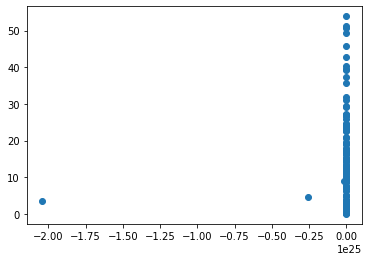

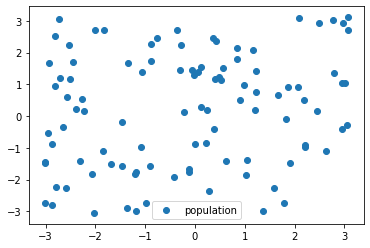

turn: 10


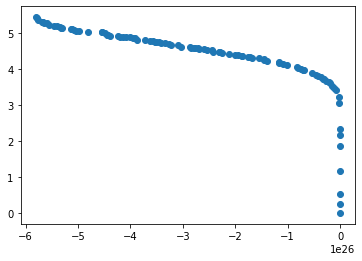

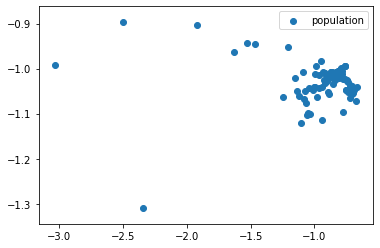

turn: 20


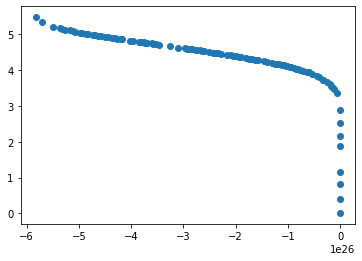

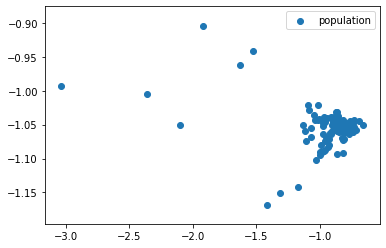

turn: 30


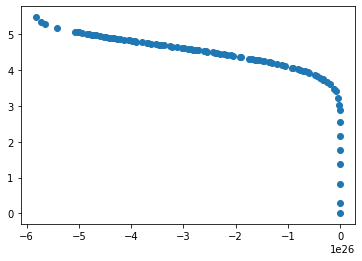

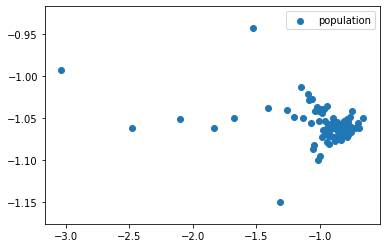

turn: 40


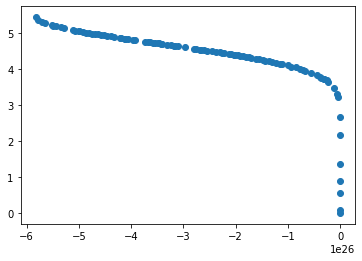

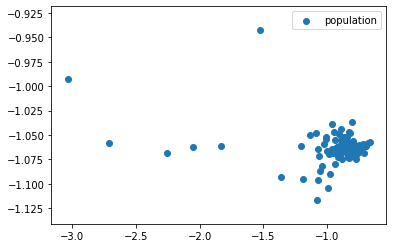

turn: 50


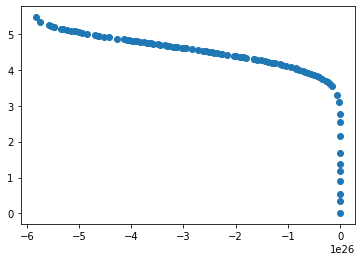

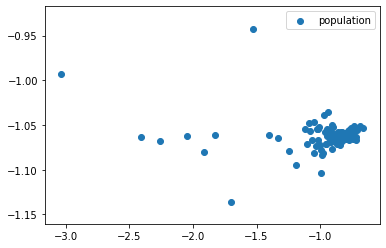

turn: 60


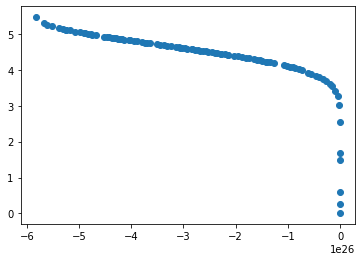

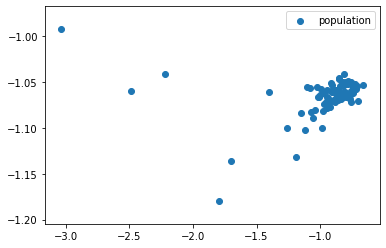

turn: 70


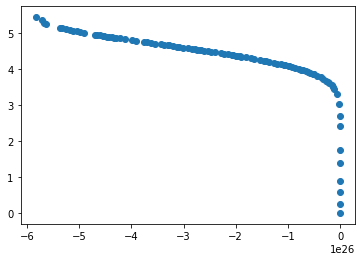

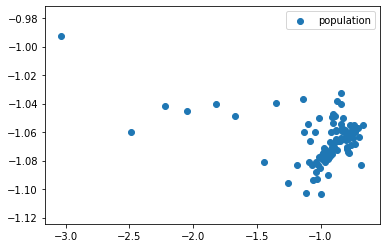

turn: 80


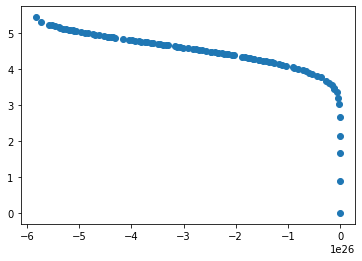

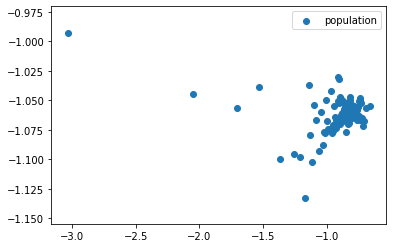

turn: 90


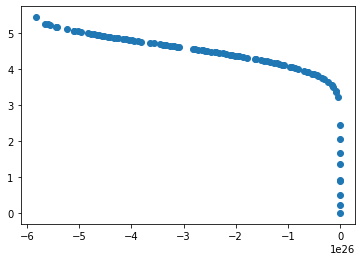

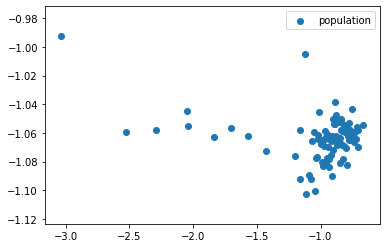

turn: 99


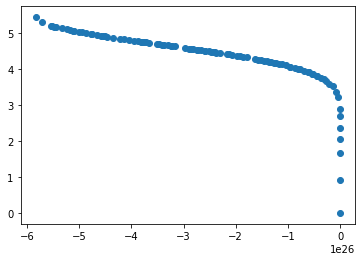

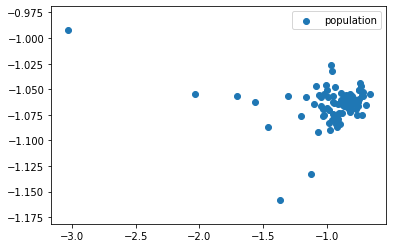

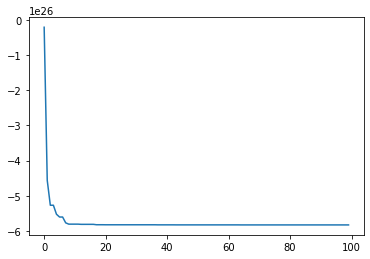

In [421]:
pollogs, polpop, polresulthistory = nsgaii( 100, 2, 100, 2, [POL1, POL2], -np.pi, np.pi)

plt.plot(polresulthistory)
plt.show()

turn: 0


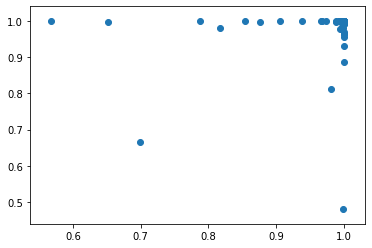

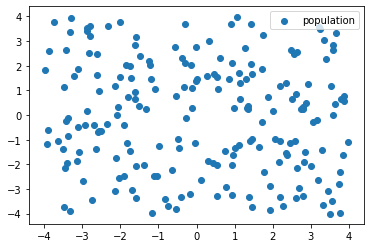

turn: 10


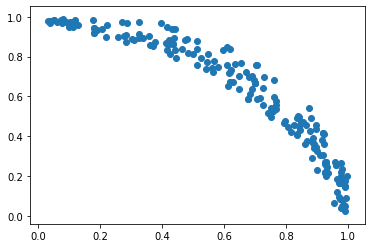

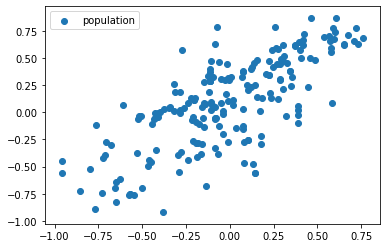

turn: 20


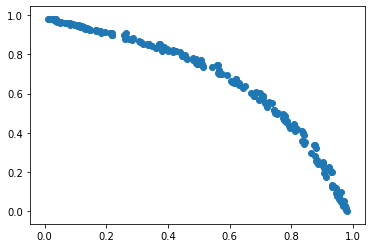

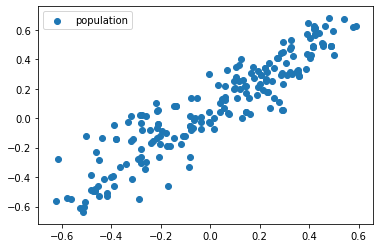

turn: 30


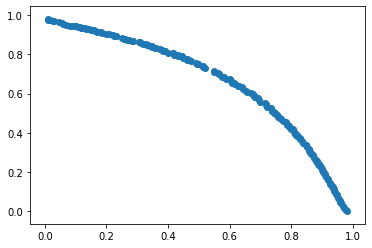

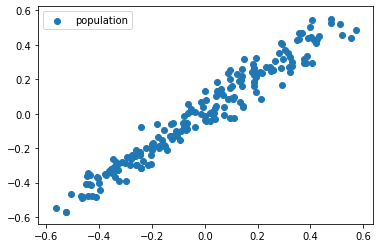

turn: 40


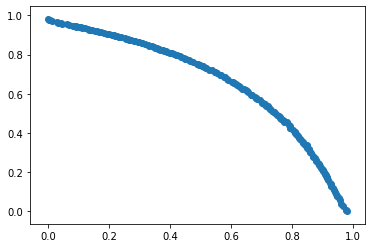

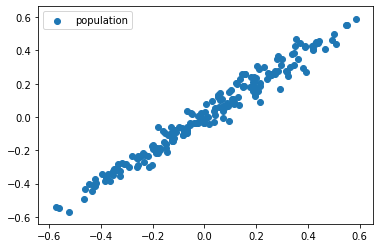

turn: 50


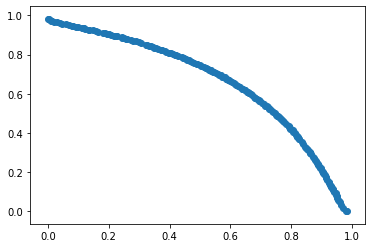

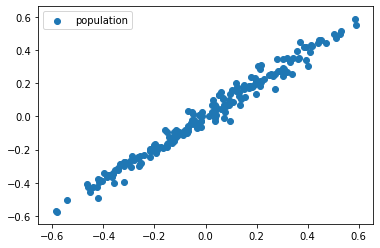

turn: 60


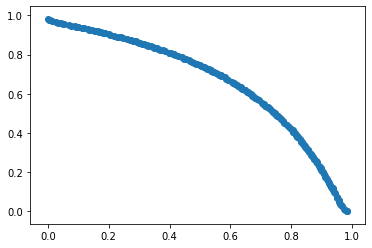

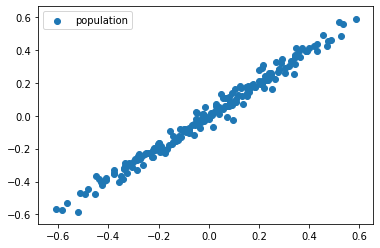

turn: 70


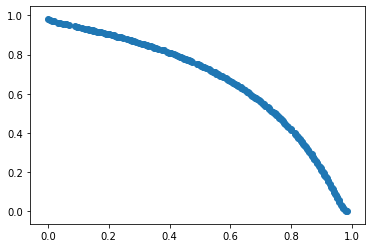

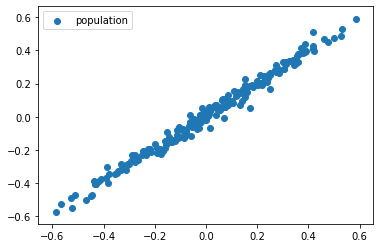

turn: 80


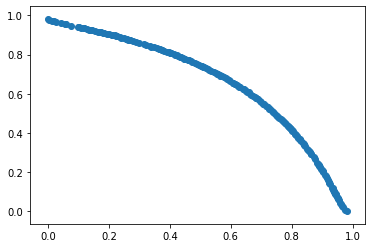

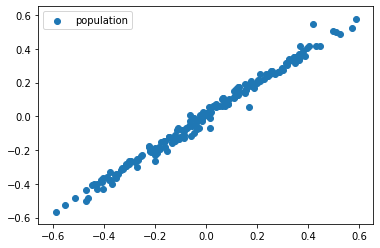

turn: 90


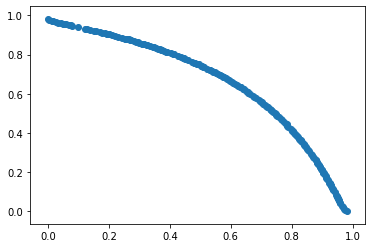

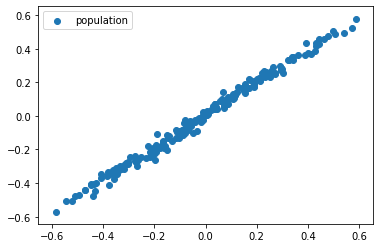

turn: 99


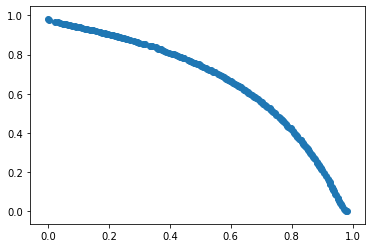

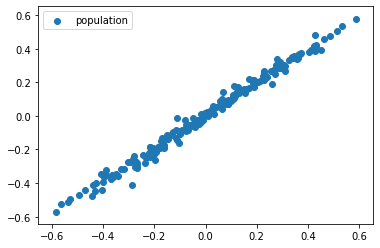

fon population:[[ 5.86421463e-01  5.79249447e-01  5.63355330e-01]
 [-5.84467542e-01 -5.69864304e-01 -5.68755577e-01]
 [-3.89787605e-01 -3.22389342e-01 -2.90446786e-01]
 [-1.14006714e-01 -8.13804376e-02 -1.10550181e-01]
 [-4.96310589e-01 -4.69565131e-01 -4.77472533e-01]
 [-2.76703370e-01 -3.02479294e-01 -3.16950616e-01]
 [ 1.28593267e-01  1.35056126e-01  1.10884636e-01]
 [ 1.63297611e-01  1.60165023e-01  1.74501719e-01]
 [-9.85115192e-02 -1.10379787e-01 -1.18890253e-01]
 [ 2.29638839e-01  2.57314513e-01  2.47294775e-01]
 [ 6.35669760e-02  1.01679234e-01  1.06067277e-01]
 [-1.76053109e-01 -1.50584057e-01 -1.52216675e-01]
 [ 1.18787445e-01  1.36643927e-01  1.43395907e-01]
 [ 2.32415225e-01  2.43540039e-01  1.23252898e-01]
 [-2.78831040e-01 -2.36196578e-01 -2.54650052e-01]
 [-3.98011300e-01 -3.66326582e-01 -3.93564467e-01]
 [-1.05256626e-01 -9.09943210e-02 -9.25095658e-02]
 [ 2.11499335e-01  2.10471024e-01  2.39606872e-01]
 [ 2.82704413e-02  5.87859999e-02  6.91549978e-02]
 [-1.16272356e-0

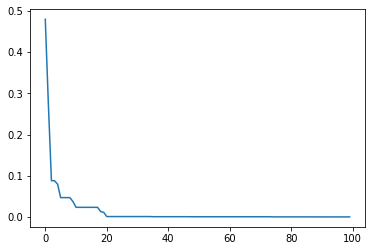

In [422]:
#nsgalogs, nsgapop = nsgaii( 100, 1, 100, 2, [SCH1, SCH2], -1000, 1000)

fonlogs, fonpop, fonresulthistory = nsgaii( 200, 3, 100, 2, [FON1, FON2], -4, 4)
print(f"fon population:{fonpop}")
plt.plot( fonresulthistory )
plt.show()

turn: 0


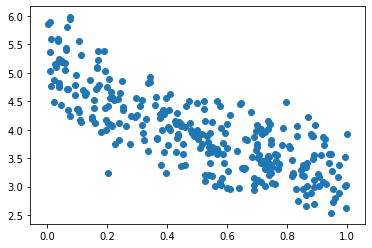

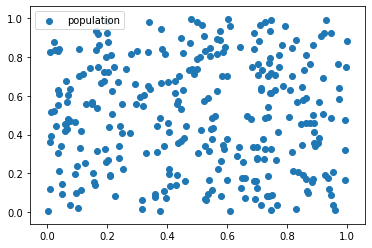

turn: 10


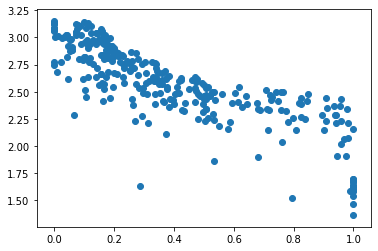

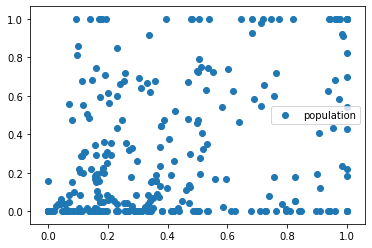

turn: 20


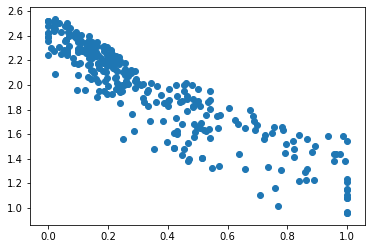

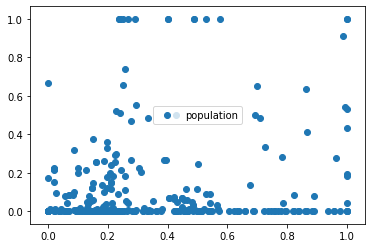

turn: 30


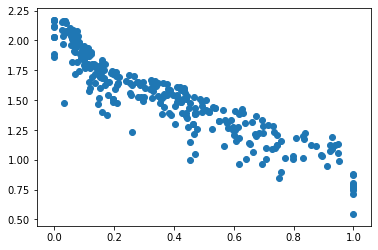

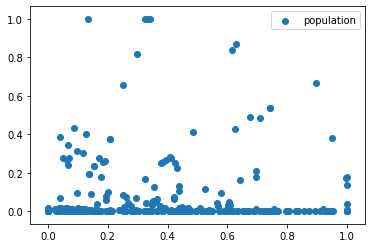

turn: 40


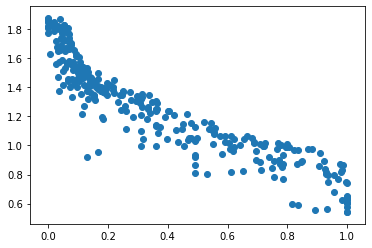

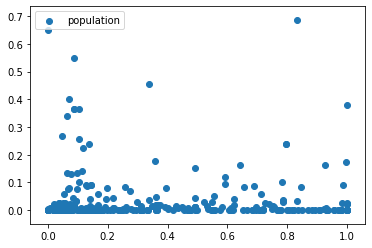

turn: 50


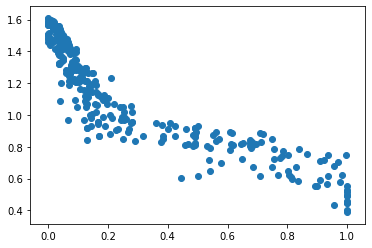

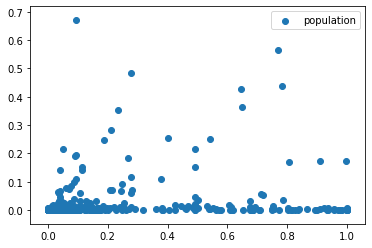

turn: 60


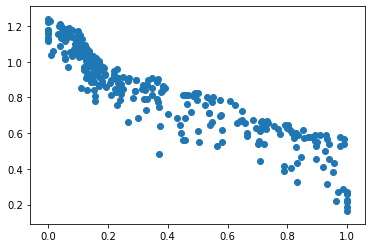

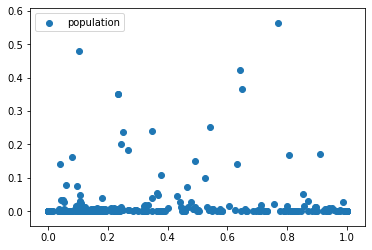

turn: 70


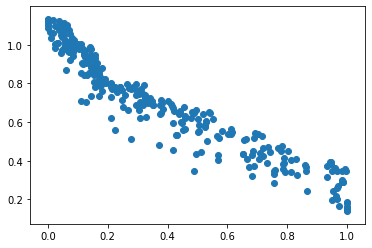

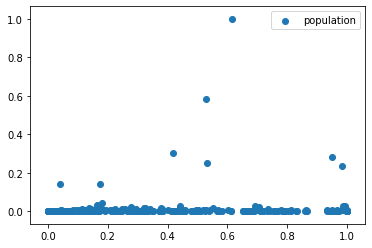

turn: 80


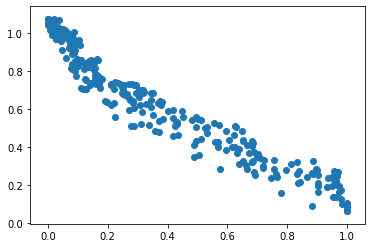

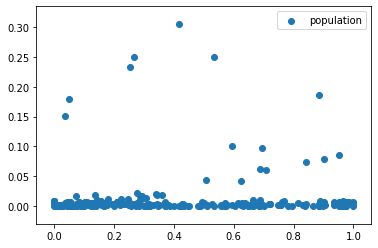

turn: 90


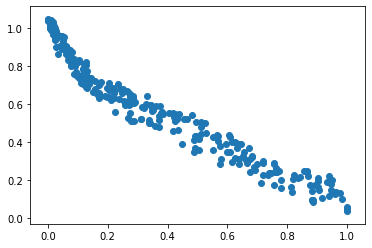

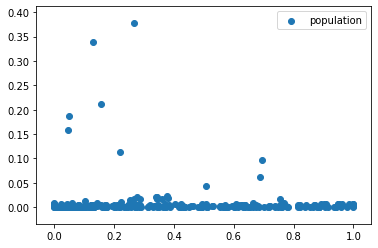

turn: 100


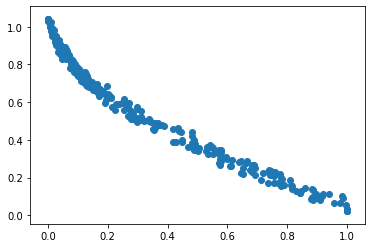

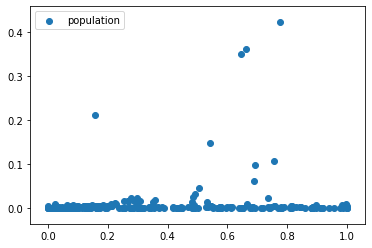

turn: 110


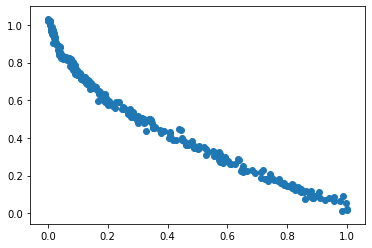

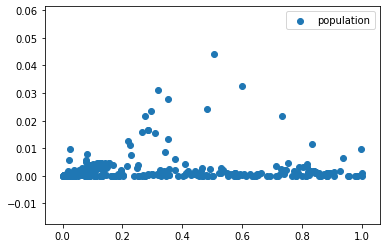

turn: 120


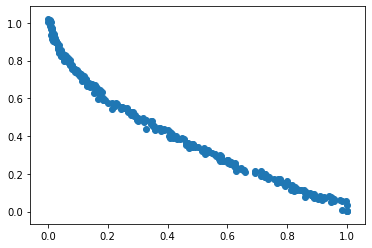

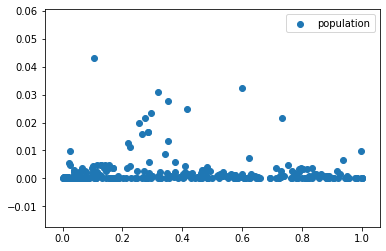

turn: 130


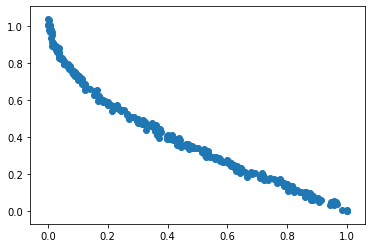

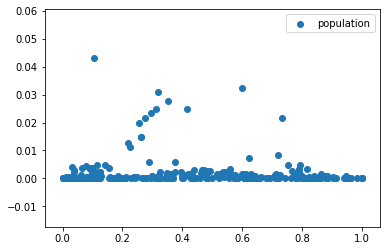

turn: 140


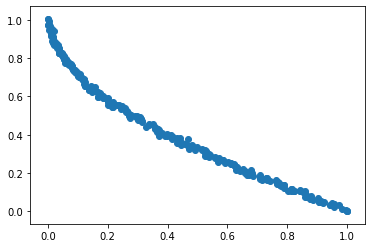

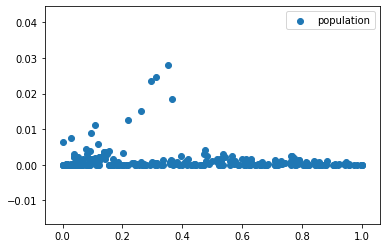

zdt1 population:[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.96970470e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [5.13692564e-01 1.01249138e-04 8.04995782e-03 ... 1.37932053e-04
  6.47198985e-06 1.95105075e-04]
 ...
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 5.35707168e-08]
 [5.77376528e-01 3.32279247e-03 2.61612004e-02 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [8.53890397e-01 1.26175010e-02 1.01762186e-02 ... 1.08918370e-04
  2.60379076e-06 8.74051886e-04]]


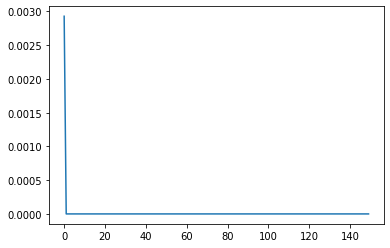

In [411]:
zdt1logs, zdt1pop, zdt1resulthistory = nsgaii( 300, 30, 300, 2, [ZDT11, ZDT12], 0, 1, iterations=150)

print(f"zdt1 population:{zdt1pop}")
plt.plot(zdt1resulthistory)
plt.show()

Zadanie 4
Multiobjective Travelling Salesman Problem

In [412]:
import tsplib95

def objfunctionforE(E, n, p):
    s = 0.0
    for i in range(n):
        s += E[p[i-1], p[i]]
    return s

def openproblem(name):
    problem = tsplib95.load(name)
    probn = problem.dimension
    probedges = problem.get_edges()
    E = np.empty((probn, probn))
    for (a, b) in probedges:
        E[a - 1, b - 1] = problem.get_weight(a, b)
    return probn, E

def initialize_population_tsp(n, d):
    current_population = np.zeros((n, d), dtype=np.int64)
    for i in range(n):
        current_population[i, :] = np.random.permutation(d)
    return current_population

def evaluatepopTSP( n, POP, funcount, func_list ):
    E = np.zeros( (n, funcount) ) # wyniki kazdej funkcji dla osobnikow
    for i in range( n ):
        for j in range( funcount ):
            E[i][j] = func_list[j](POP[i])
    return E

In [413]:
def nsgaiiTSP(n, d, number_of_offspring, funcount, func_list, crossover_probability = 0.95, mutation_probability = 1, iterations = 100):
    population_size = n
    POP = initialize_population_tsp(n, d)

    E = evaluatepopTSP(n, POP, funcount, func_list)

    elogs = np.empty( (iterations, n, funcount) )
    bestresulthistory = np.empty( iterations )
    bestres = np.Inf
    for turn in range(iterations):
        #print(f"E:{E}")
        #print(f"elogs shape:{elogs.shape}, E.shape:{E.shape}\n")
        elogs[turn,:,:] = E[:,:]
        bestres = min(bestres, E.min())
        bestresulthistory[turn] = bestres

        if turn % 10 == 0:
            print(f"turn: {turn}")
            plt.scatter( E[:,0], E[:,1] )
            plt.show()

        # selecting the parent indices by the roulette wheel method
        minE = np.min(E, axis=1)
        fitness_values = minE.max() - minE
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        #print(f"fitness values:{fitness_values}")
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)
        #print(f"parent indices:{parent_indices}")

        # creating the children population
        children_population = np.zeros((number_of_offspring, d), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = PMX(POP[parent_indices[2*i], :].copy(), POP[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = POP[parent_indices[2*i], :].copy(), POP[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = POP[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = reverse_sequence_mutation(children_population[i, :])
            
        # evaluating the objective function on the children population
        children_objective_values = evaluatepopTSP(number_of_offspring, children_population, funcount, func_list)

        #if turn % 10 == 0:
        #    plt.scatter( children_population[:,0], children_population[:,1], label="children x1 x2" )
        #    plt.legend()
        #    plt.show()
        #    plt.scatter( children_objective_values[:,0], children_objective_values[:,1], label="children obj values" )
        #    plt.legend()
        #    plt.show()

        # replacing the current population by (Mu + Lambda) Replacement
        E = np.vstack([E, children_objective_values])
        POP = np.vstack([POP, children_population])

        ranked = rank_population(n + number_of_offspring, funcount, func_list, E)
        #print(f"ranked:{ranked}")

        POP = POP[ ranked[:n], : ]

        #print(f"E before choosing ranked:{E}")
        E = E[ ranked[:n] ]
        #print(f"E after choosing ranked:{E}")
    
    return elogs, POP, bestresulthistory


turn: 0


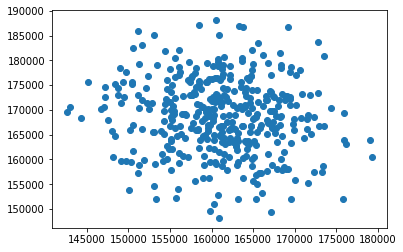

turn: 10


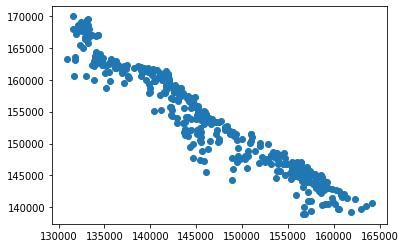

turn: 20


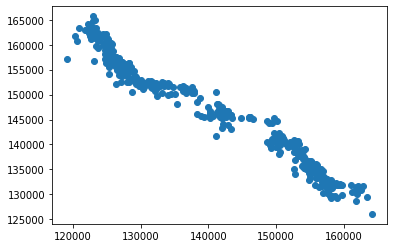

turn: 30


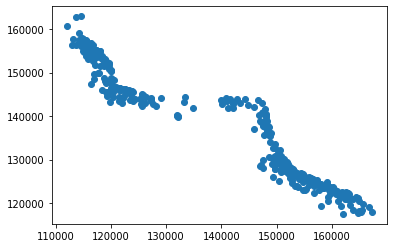

turn: 40


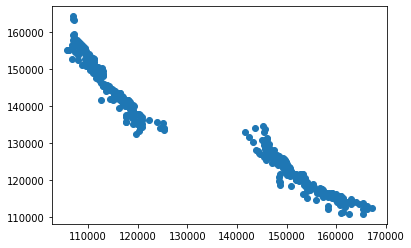

turn: 50


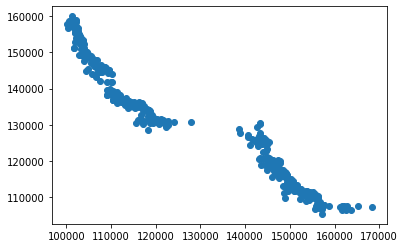

turn: 60


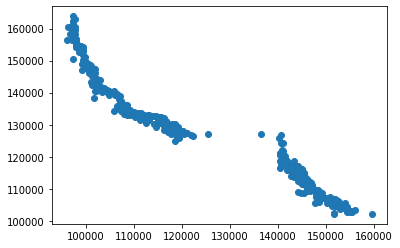

turn: 70


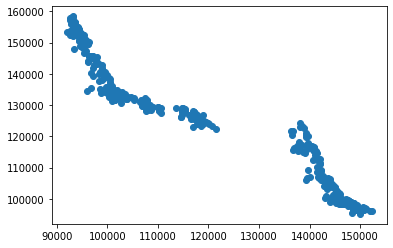

turn: 80


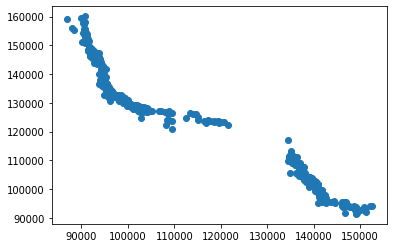

turn: 90


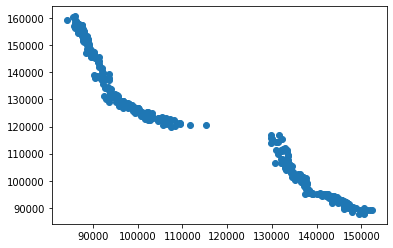

turn: 100


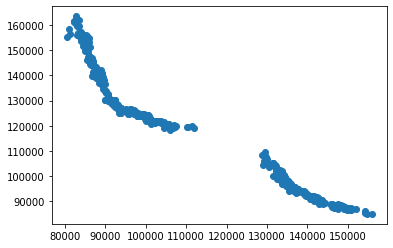

turn: 110


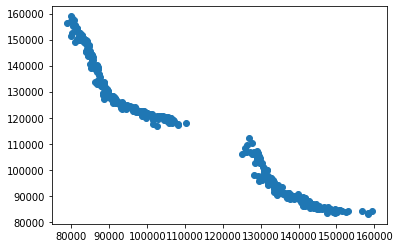

turn: 120


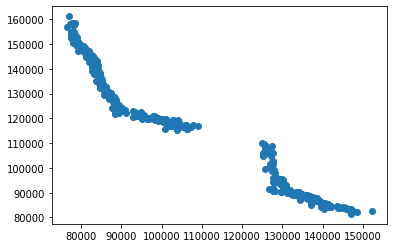

turn: 130


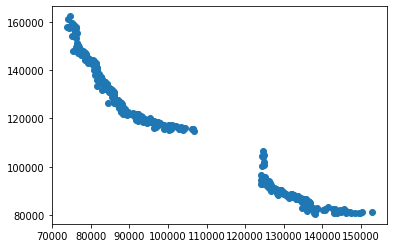

turn: 140


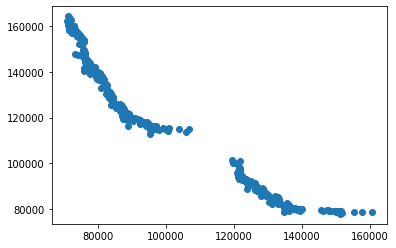

turn: 150


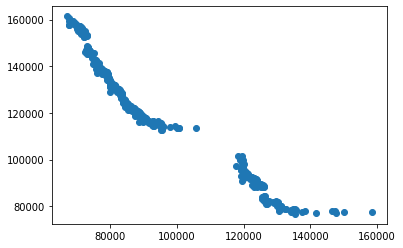

turn: 160


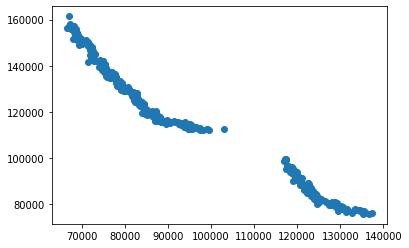

turn: 170


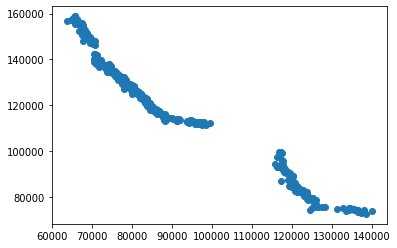

turn: 180


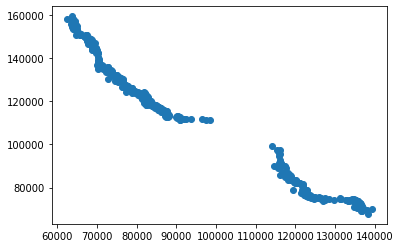

turn: 190


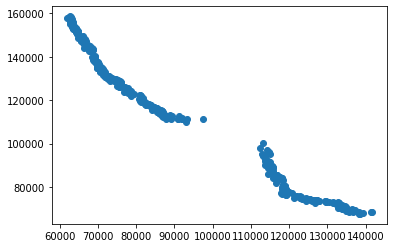

In [417]:
euclidA100n, euclidA100E = openproblem("euclidA100.tsp")
euclidB100n, euclidB100E = openproblem("euclidB100.tsp")

def euclidABf1( p ):
    return objfunctionforE(euclidA100E, euclidA100n, p)

def euclidABf2( p ):
    return objfunctionforE(euclidB100E, euclidB100n, p)

tspABlogs, tspABpop, tspABresulthistory = nsgaiiTSP( 400, 100, 400, 2, [euclidABf1, euclidABf2], iterations=200)

turn: 0


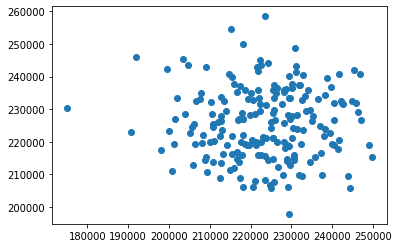

turn: 10


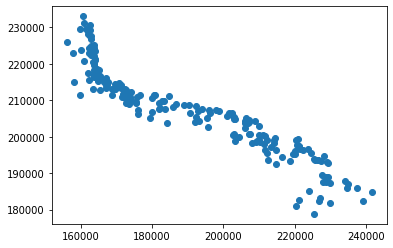

turn: 20


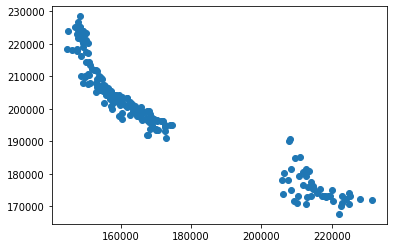

turn: 30


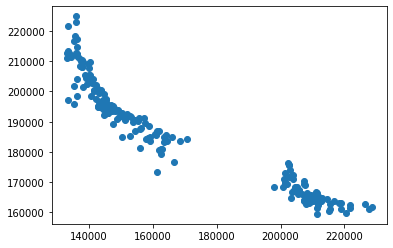

turn: 40


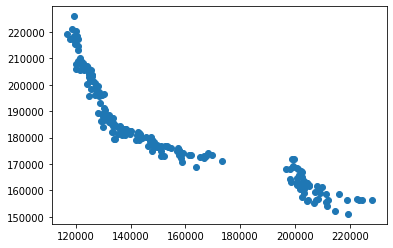

turn: 50


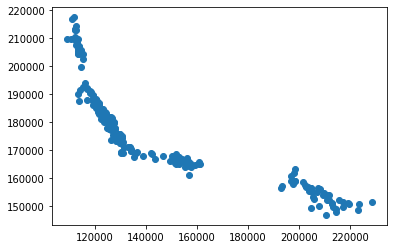

turn: 60


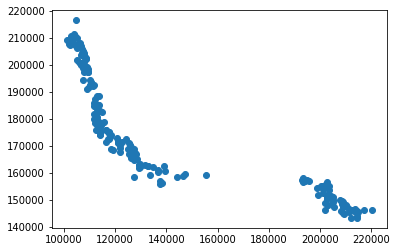

turn: 70


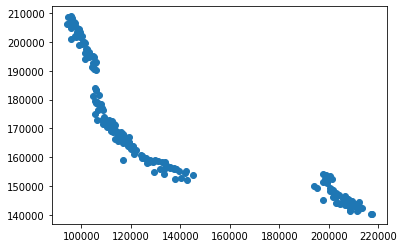

turn: 80


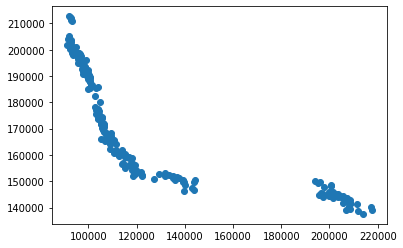

turn: 90


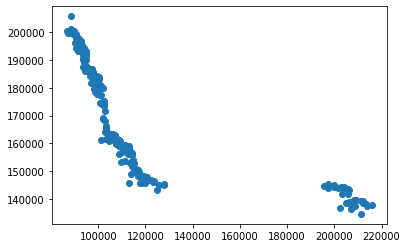

turn: 100


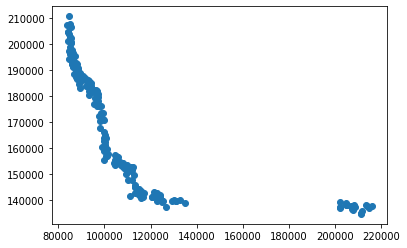

turn: 110


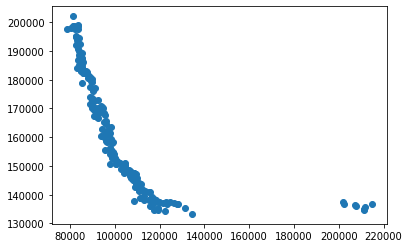

turn: 120


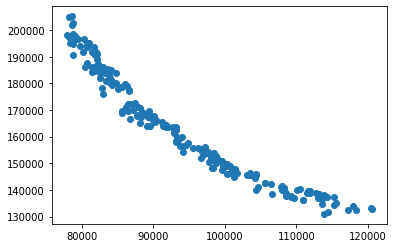

turn: 130


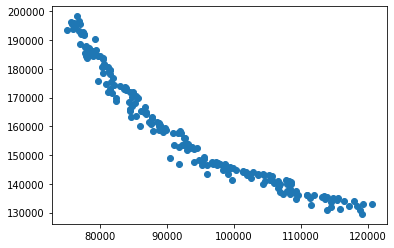

turn: 140


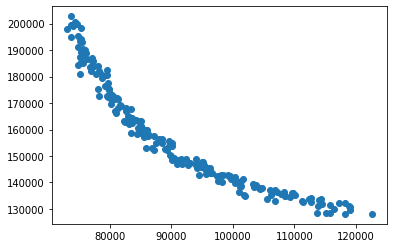

turn: 150


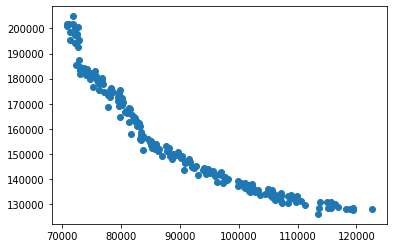

turn: 160


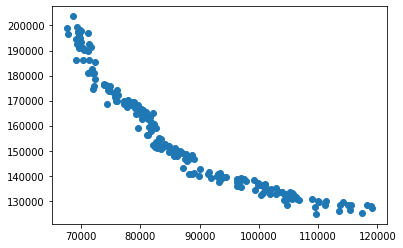

turn: 170


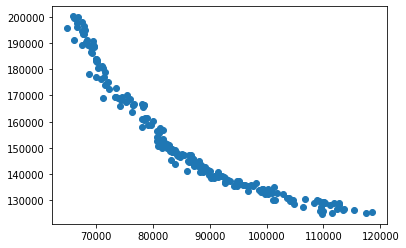

turn: 180


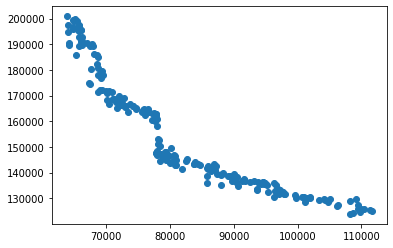

turn: 190


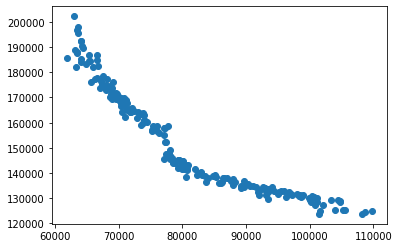

In [415]:
randomA100n, randomA100E = openproblem("randomA100.tsp")
randomB100n, randomB100E = openproblem("randomB100.tsp")

def randomABf1( p ):
    return objfunctionforE(randomA100E, randomA100n, p)

def randomABf2( p ):
    return objfunctionforE(randomB100E, randomB100n, p)

randomABlogs, randomABpop, randomABresulthistory = nsgaiiTSP( 200, 100, 200, 2, [randomABf1, randomABf2], iterations=200)

turn: 0


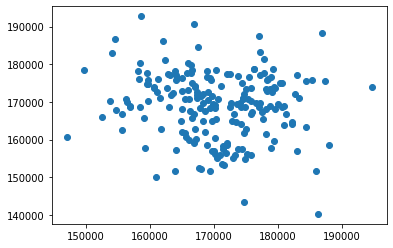

turn: 10


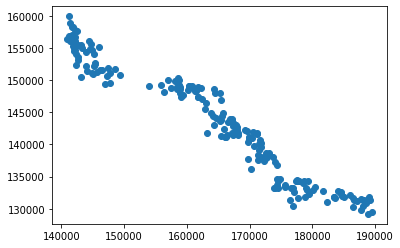

turn: 20


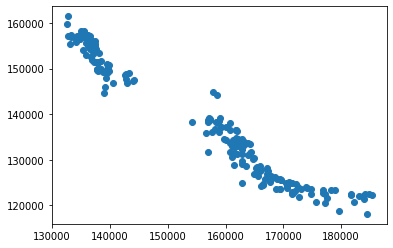

turn: 30


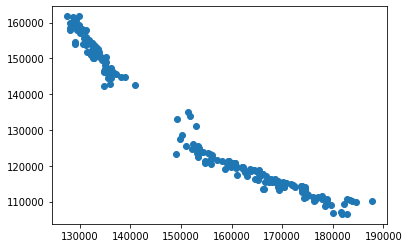

turn: 40


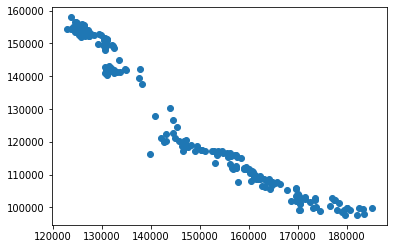

turn: 50


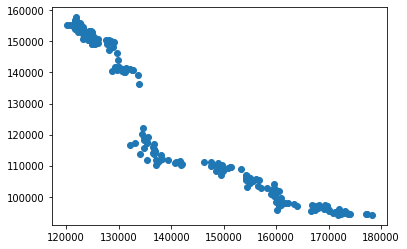

turn: 60


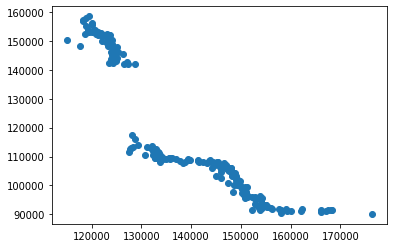

turn: 70


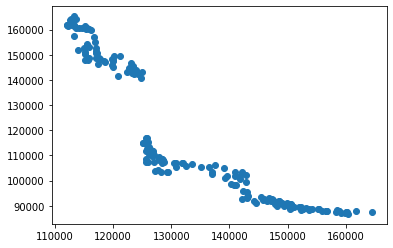

turn: 80


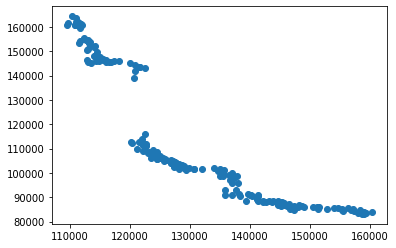

turn: 90


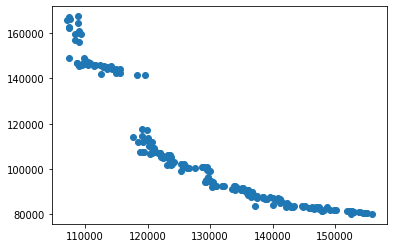

turn: 100


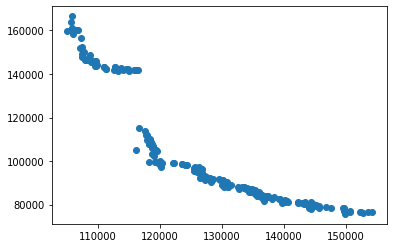

turn: 110


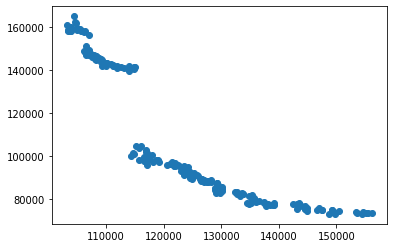

turn: 120


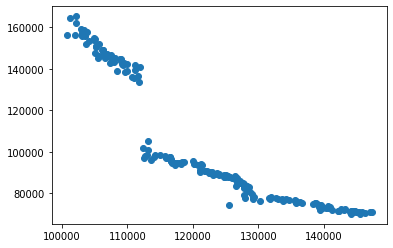

turn: 130


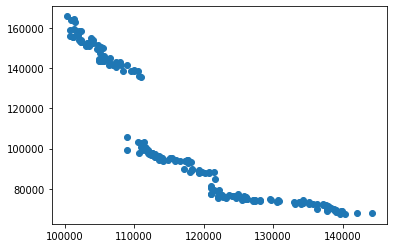

turn: 140


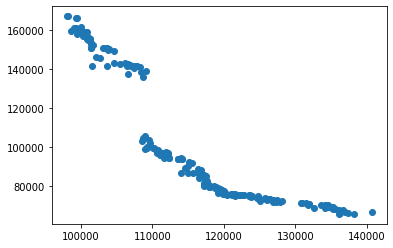

turn: 150


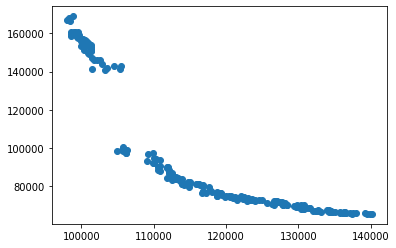

turn: 160


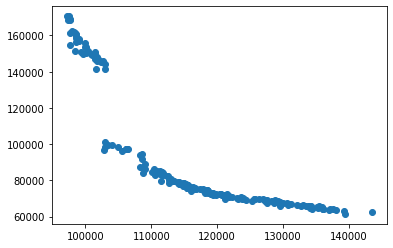

turn: 170


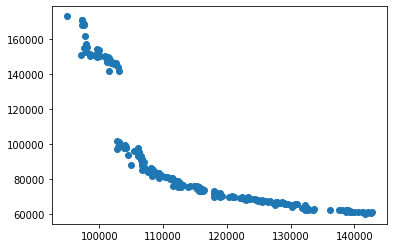

turn: 180


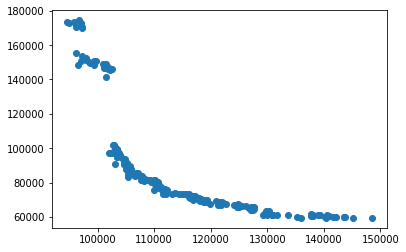

turn: 190


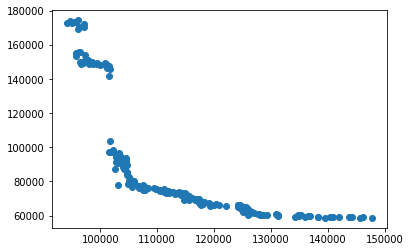

In [416]:
kroA100n, kroA100E = openproblem("kroA100.tsp")
kroB100n, kroB100E = openproblem("kroB100.tsp")

def kroABf1( p ):
    return objfunctionforE(kroA100E, kroA100n, p)

def kroABf2( p ):
    return objfunctionforE(kroB100E, kroB100n, p)

kroABlogs, kroABpop, kroABresulthistory = nsgaiiTSP( 200, 100, 200, 2, [kroABf1, kroABf2], iterations=200)